In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import pandas as pd
df_train = pd.read_csv('/content/drive/MyDrive/SMM4H 2024/SMM4H-2024-Task5-Training.tsv', sep='\t')
df_dev = pd.read_csv('/content/drive/MyDrive/SMM4H 2024/SMM4H-2024-Task5-Validation.tsv', sep='\t')

In [2]:
!pip install transformers seqeval torch tqdm accelerate sentencepiece datasets

In [3]:
from datasets import load_metric
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, IntervalStrategy
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
from accelerate import Accelerator
import numpy as np
import torch
import os
class TextDataset(Dataset):
    def __init__(self, tokenizer, texts, labels):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=512)
        self.labels = labels
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item
    def __len__(self):
        return len(self.labels)
texts = df_train['text'].tolist()
labels = df_train['label'].tolist()
tokenizer = AutoTokenizer.from_pretrained('microsoft/Multilingual-MiniLM-L12-H384')
model = AutoModelForSequenceClassification.from_pretrained('microsoft/Multilingual-MiniLM-L12-H384')
train_dataset = TextDataset(tokenizer, texts, labels)
training_args = TrainingArguments(
    output_dir='./results_temp',  # Temporarily save here
    num_train_epochs=5,  # Adjusted for demonstration
    learning_rate=2e-5,
    per_device_train_batch_size=36,
    per_device_eval_batch_size=36,
    warmup_steps=0,
    weight_decay=0.05,
    logging_dir='./logs',
    logging_steps=100,
    evaluation_strategy=IntervalStrategy.NO,
    save_strategy=IntervalStrategy.EPOCH,
    load_best_model_at_end=False,  # Ensure models are saved regardless of performance
)
class CustomTrainer(Trainer):
    def on_train_end(self, args, state, control, **kwargs):
        super().on_train_end(args, state, control, **kwargs)
        for epoch in range(1, int(training_args.num_train_epochs) + 1):
            epoch_dir = f"./miniLM_model_{epoch}"
            os.rename(f"{training_args.output_dir}/checkpoint-{epoch}", epoch_dir)
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
)
trainer.train()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of BertForSequenceClassification were not initialized from the model checkpo

Step,Training Loss
100,0.619400
200,0.558500
300,0.489000
400,0.479100
500,0.423400
600,0.432500
700,0.373600
800,0.372700
900,0.352100
1000,0.345200


TrainOutput(global_step=1030, training_loss=0.44145730213054174, metrics={'train_runtime': 316.3393, 'train_samples_per_second': 116.931, 'train_steps_per_second': 3.256, 'total_flos': 1698979934380680.0, 'train_loss': 0.44145730213054174, 'epoch': 5.0})

Evaluating:   0%|          | 0/11 [00:00<?, ?it/s]

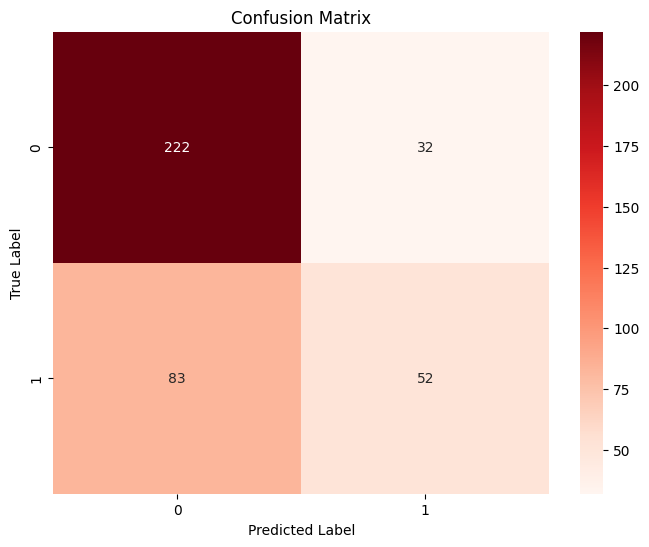

Accuracy: 0.7043701799485861
F1 Score (Class 1): 0.47488584474885837
Recall (Macro): 0.6296004666083406
Precision (Macro): 0.6734582357533178


In [6]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
class TextDataset(Dataset):
    def __init__(self, tokenizer, texts, labels=None):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=512)
        self.labels = labels if labels is not None else [0] * len(texts)
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels is not None:
            item['labels'] = torch.tensor(self.labels[idx])
        return item
    def __len__(self):
        return len(self.encodings['input_ids'])
tokenizer = AutoTokenizer.from_pretrained('microsoft/Multilingual-MiniLM-L12-H384')
model = AutoModelForSequenceClassification.from_pretrained('/content/results_temp/checkpoint-206')
model = model.to('cuda')
dev_texts = df_dev['text'].tolist()
dev_dataset = TextDataset(tokenizer, dev_texts)
dev_loader = DataLoader(dev_dataset, batch_size=36, shuffle=False)
predictions = []
for batch in tqdm(dev_loader, desc="Evaluating"):
    inputs = {k: v.to(model.device) for k, v in batch.items() if k != 'labels'}
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    probabilities = torch.nn.functional.softmax(logits, dim=1)
    pred_labels = logits.argmax(1)
    predictions.extend(zip(pred_labels.cpu().numpy(), probabilities[:,0].cpu().numpy(), probabilities[:,1].cpu().numpy()))
df_predictions_1 = pd.DataFrame(predictions, columns=['predicted_label', 'prediction_0_weight', 'prediction_1_weight'])
df_merged_1 = pd.concat([df_dev, df_predictions_1], axis=1)
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, recall_score, precision_score
import matplotlib.pyplot as plt
import seaborn as sns
true_labels = df_merged_1['label']
predicted_labels = df_merged_1['predicted_label']
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
accuracy = accuracy_score(true_labels, predicted_labels)
f1_class_1 = f1_score(true_labels, predicted_labels, pos_label=1)
recall_macro = recall_score(true_labels, predicted_labels, average='macro')
precision_macro = precision_score(true_labels, predicted_labels, average='macro')
print(f"Accuracy: {accuracy}")
print(f"F1 Score (Class 1): {f1_class_1}")
print(f"Recall (Macro): {recall_macro}")
print(f"Precision (Macro): {precision_macro}")
df_merged_1.to_csv('MiniLM_task5_predictions_epoch_1.csv', index=False)

Evaluating:   0%|          | 0/11 [00:00<?, ?it/s]

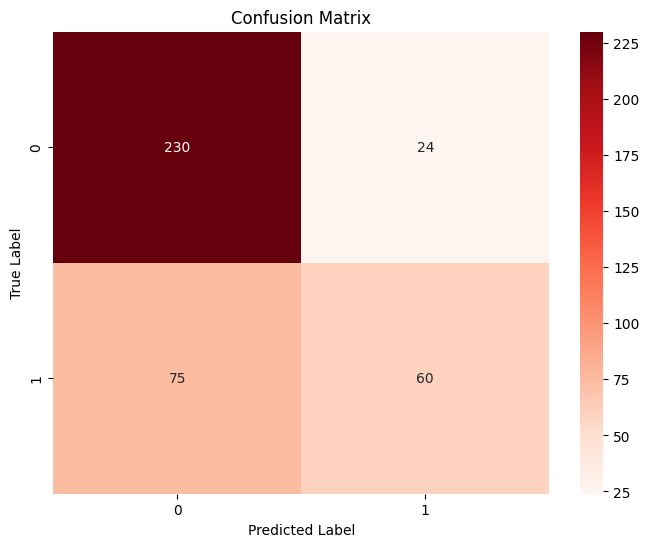

Accuracy: 0.7455012853470437
F1 Score (Class 1): 0.5479452054794521
Recall (Macro): 0.6749781277340332
Precision (Macro): 0.734192037470726


In [7]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
class TextDataset(Dataset):
    def __init__(self, tokenizer, texts, labels=None):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=512)
        self.labels = labels if labels is not None else [0] * len(texts)
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels is not None:
            item['labels'] = torch.tensor(self.labels[idx])
        return item
    def __len__(self):
        return len(self.encodings['input_ids'])
tokenizer = AutoTokenizer.from_pretrained('microsoft/Multilingual-MiniLM-L12-H384')
model = AutoModelForSequenceClassification.from_pretrained('/content/results_temp/checkpoint-412')                              # HERE
model = model.to('cuda')
dev_texts = df_dev['text'].tolist()
dev_dataset = TextDataset(tokenizer, dev_texts)
dev_loader = DataLoader(dev_dataset, batch_size=36, shuffle=False)
predictions = []
for batch in tqdm(dev_loader, desc="Evaluating"):
    inputs = {k: v.to(model.device) for k, v in batch.items() if k != 'labels'}
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    probabilities = torch.nn.functional.softmax(logits, dim=1)
    pred_labels = logits.argmax(1)
    predictions.extend(zip(pred_labels.cpu().numpy(), probabilities[:,0].cpu().numpy(), probabilities[:,1].cpu().numpy()))
df_predictions_2 = pd.DataFrame(predictions, columns=['predicted_label', 'prediction_0_weight', 'prediction_1_weight'])          # HERE
df_merged_2 = pd.concat([df_dev, df_predictions_2], axis=1)                                                                      # HERE  # HERE
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, recall_score, precision_score
import matplotlib.pyplot as plt
import seaborn as sns
true_labels = df_merged_2['label']                                                                                               # HERE
predicted_labels = df_merged_2['predicted_label']                                                                                # HERE
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
accuracy = accuracy_score(true_labels, predicted_labels)
f1_class_1 = f1_score(true_labels, predicted_labels, pos_label=1)
recall_macro = recall_score(true_labels, predicted_labels, average='macro')
precision_macro = precision_score(true_labels, predicted_labels, average='macro')
print(f"Accuracy: {accuracy}")
print(f"F1 Score (Class 1): {f1_class_1}")
print(f"Recall (Macro): {recall_macro}")
print(f"Precision (Macro): {precision_macro}")
df_merged_2.to_csv('MiniLM_task5_predictions_epoch_2.csv', index=False)                                                          # HERE  # HERE

Evaluating:   0%|          | 0/11 [00:00<?, ?it/s]

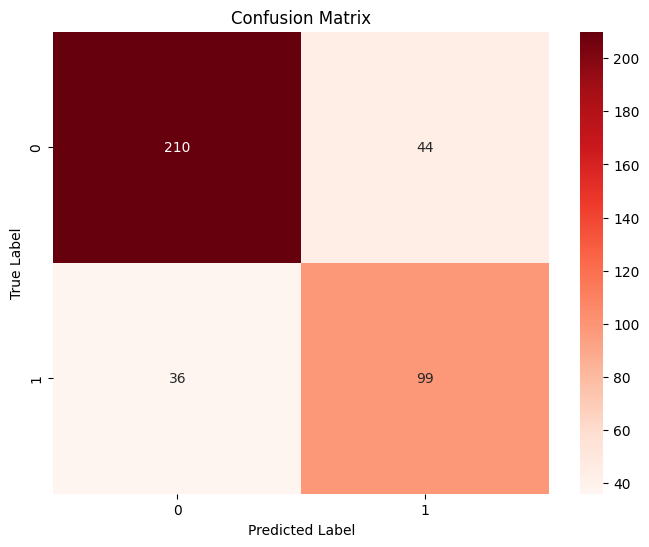

Accuracy: 0.794344473007712
F1 Score (Class 1): 0.7122302158273381
Recall (Macro): 0.7800524934383202
Precision (Macro): 0.7729831144465291


In [8]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
class TextDataset(Dataset):
    def __init__(self, tokenizer, texts, labels=None):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=512)
        self.labels = labels if labels is not None else [0] * len(texts)
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels is not None:
            item['labels'] = torch.tensor(self.labels[idx])
        return item
    def __len__(self):
        return len(self.encodings['input_ids'])
tokenizer = AutoTokenizer.from_pretrained('microsoft/Multilingual-MiniLM-L12-H384')
model = AutoModelForSequenceClassification.from_pretrained('/content/results_temp/checkpoint-618')                              # HERE
model = model.to('cuda')
dev_texts = df_dev['text'].tolist()
dev_dataset = TextDataset(tokenizer, dev_texts)
dev_loader = DataLoader(dev_dataset, batch_size=36, shuffle=False)
predictions = []
for batch in tqdm(dev_loader, desc="Evaluating"):
    inputs = {k: v.to(model.device) for k, v in batch.items() if k != 'labels'}
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    probabilities = torch.nn.functional.softmax(logits, dim=1)
    pred_labels = logits.argmax(1)
    predictions.extend(zip(pred_labels.cpu().numpy(), probabilities[:,0].cpu().numpy(), probabilities[:,1].cpu().numpy()))
df_predictions_3 = pd.DataFrame(predictions, columns=['predicted_label', 'prediction_0_weight', 'prediction_1_weight'])          # HERE
df_merged_3 = pd.concat([df_dev, df_predictions_3], axis=1)                                                                      # HERE  # HERE
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, recall_score, precision_score
import matplotlib.pyplot as plt
import seaborn as sns
true_labels = df_merged_3['label']                                                                                               # HERE
predicted_labels = df_merged_3['predicted_label']                                                                                # HERE
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
accuracy = accuracy_score(true_labels, predicted_labels)
f1_class_1 = f1_score(true_labels, predicted_labels, pos_label=1)
recall_macro = recall_score(true_labels, predicted_labels, average='macro')
precision_macro = precision_score(true_labels, predicted_labels, average='macro')
print(f"Accuracy: {accuracy}")
print(f"F1 Score (Class 1): {f1_class_1}")
print(f"Recall (Macro): {recall_macro}")
print(f"Precision (Macro): {precision_macro}")
df_merged_3.to_csv('MiniLM_task5_predictions_epoch_3.csv', index=False)                                                          # HERE  # HERE

Evaluating:   0%|          | 0/11 [00:00<?, ?it/s]

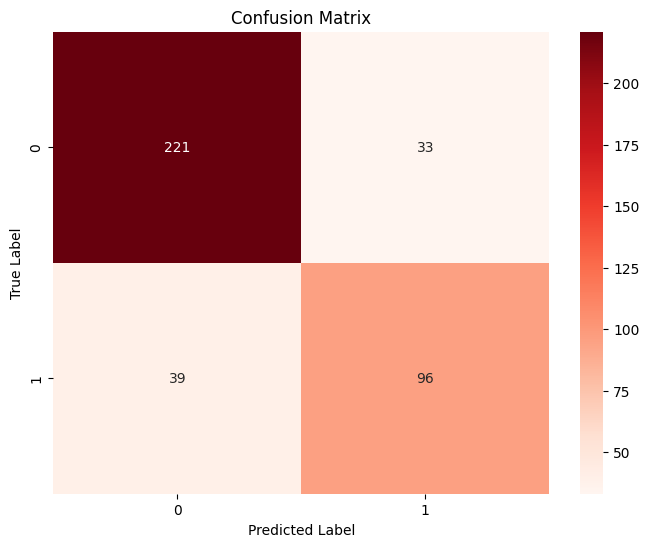

Accuracy: 0.8149100257069408
F1 Score (Class 1): 0.7272727272727273
Recall (Macro): 0.7905949256342957
Precision (Macro): 0.797093023255814


In [9]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
class TextDataset(Dataset):
    def __init__(self, tokenizer, texts, labels=None):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=512)
        self.labels = labels if labels is not None else [0] * len(texts)
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels is not None:
            item['labels'] = torch.tensor(self.labels[idx])
        return item
    def __len__(self):
        return len(self.encodings['input_ids'])
tokenizer = AutoTokenizer.from_pretrained('microsoft/Multilingual-MiniLM-L12-H384')
model = AutoModelForSequenceClassification.from_pretrained('/content/results_temp/checkpoint-824')                              # HERE
model = model.to('cuda')
dev_texts = df_dev['text'].tolist()
dev_dataset = TextDataset(tokenizer, dev_texts)
dev_loader = DataLoader(dev_dataset, batch_size=36, shuffle=False)
predictions = []
for batch in tqdm(dev_loader, desc="Evaluating"):
    inputs = {k: v.to(model.device) for k, v in batch.items() if k != 'labels'}
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    probabilities = torch.nn.functional.softmax(logits, dim=1)
    pred_labels = logits.argmax(1)
    predictions.extend(zip(pred_labels.cpu().numpy(), probabilities[:,0].cpu().numpy(), probabilities[:,1].cpu().numpy()))
df_predictions_4 = pd.DataFrame(predictions, columns=['predicted_label', 'prediction_0_weight', 'prediction_1_weight'])          # HERE
df_merged_4 = pd.concat([df_dev, df_predictions_4], axis=1)                                                                      # HERE  # HERE
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, recall_score, precision_score
import matplotlib.pyplot as plt
import seaborn as sns
true_labels = df_merged_4['label']                                                                                               # HERE
predicted_labels = df_merged_4['predicted_label']                                                                                # HERE
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
accuracy = accuracy_score(true_labels, predicted_labels)
f1_class_1 = f1_score(true_labels, predicted_labels, pos_label=1)
recall_macro = recall_score(true_labels, predicted_labels, average='macro')
precision_macro = precision_score(true_labels, predicted_labels, average='macro')
print(f"Accuracy: {accuracy}")
print(f"F1 Score (Class 1): {f1_class_1}")
print(f"Recall (Macro): {recall_macro}")
print(f"Precision (Macro): {precision_macro}")
df_merged_4.to_csv('MiniLM_task5_predictions_epoch_4.csv', index=False)                                                          # HERE  # HERE

Evaluating:   0%|          | 0/11 [00:00<?, ?it/s]

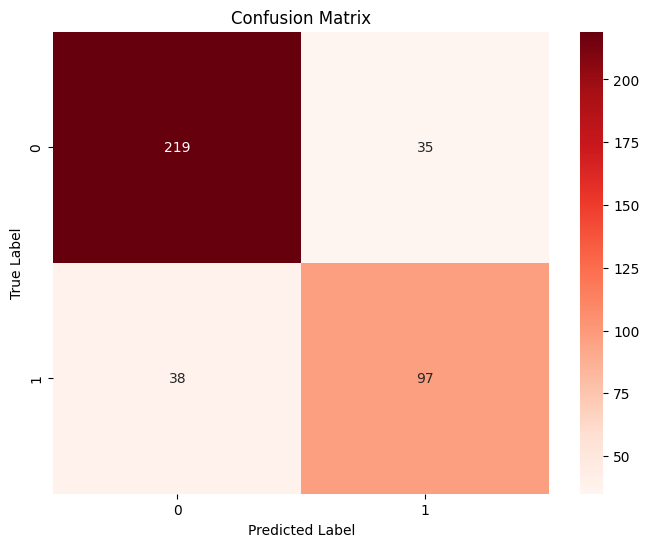

Accuracy: 0.8123393316195373
F1 Score (Class 1): 0.7265917602996255
Recall (Macro): 0.7903616214639837
Precision (Macro): 0.7934942813347483


In [10]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
class TextDataset(Dataset):
    def __init__(self, tokenizer, texts, labels=None):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=512)
        self.labels = labels if labels is not None else [0] * len(texts)
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels is not None:
            item['labels'] = torch.tensor(self.labels[idx])
        return item
    def __len__(self):
        return len(self.encodings['input_ids'])
tokenizer = AutoTokenizer.from_pretrained('microsoft/Multilingual-MiniLM-L12-H384')
model = AutoModelForSequenceClassification.from_pretrained('/content/results_temp/checkpoint-1030')                              # HERE
model = model.to('cuda')
dev_texts = df_dev['text'].tolist()
dev_dataset = TextDataset(tokenizer, dev_texts)
dev_loader = DataLoader(dev_dataset, batch_size=36, shuffle=False)
predictions = []
for batch in tqdm(dev_loader, desc="Evaluating"):
    inputs = {k: v.to(model.device) for k, v in batch.items() if k != 'labels'}
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    probabilities = torch.nn.functional.softmax(logits, dim=1)
    pred_labels = logits.argmax(1)
    predictions.extend(zip(pred_labels.cpu().numpy(), probabilities[:,0].cpu().numpy(), probabilities[:,1].cpu().numpy()))
df_predictions_5 = pd.DataFrame(predictions, columns=['predicted_label', 'prediction_0_weight', 'prediction_1_weight'])          # HERE
df_merged_5 = pd.concat([df_dev, df_predictions_5], axis=1)                                                                      # HERE  # HERE
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, recall_score, precision_score
import matplotlib.pyplot as plt
import seaborn as sns
true_labels = df_merged_5['label']                                                                                               # HERE
predicted_labels = df_merged_5['predicted_label']                                                                                # HERE
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
accuracy = accuracy_score(true_labels, predicted_labels)
f1_class_1 = f1_score(true_labels, predicted_labels, pos_label=1)
recall_macro = recall_score(true_labels, predicted_labels, average='macro')
precision_macro = precision_score(true_labels, predicted_labels, average='macro')
print(f"Accuracy: {accuracy}")
print(f"F1 Score (Class 1): {f1_class_1}")
print(f"Recall (Macro): {recall_macro}")
print(f"Precision (Macro): {precision_macro}")
df_merged_5.to_csv('MiniLM_task5_predictions_epoch_5.csv', index=False)                                                          # HERE  # HERE